In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [43]:
def mean_squared_error(y_true, y_pred, squared=True):
    t = np.sum((y_true - y_pred) ** 2) / y_true.shape[0]
    if squared:
        return t
    return np.sqrt(t)

def train_test_split(data, label, validation_size=None, test_size=None):
    if not validation_size:
        validation_size = 0.2
    if not test_size:
        test_size = 0.2
    size = data.shape[0]
    # ratio ?
    if validation_size < 1:
        validation_size = int(validation_size * size)
    if test_size < 1:
        test_size = int(test_size * size)
    # shuffle data
    random_indices = np.arange(size)
    np.random.shuffle(random_indices)
    data = data[random_indices]
    label = label[random_indices]
    # split data
    X_train, X_val, X_test = data[validation_size+test_size:], data[test_size: test_size+validation_size], data[:test_size]
    y_train, y_val, y_test= label[validation_size+test_size:], label[test_size: test_size+validation_size], label[:test_size]
    return X_train, X_val, X_test, y_train, y_val, y_test

# one hot encoder
def E(x, classes):
    return np.eye(classes)[x]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    t = sigmoid(x)
    return t * (1 - t)

def identity(x):
    return x

def d_identity(x):
    return x / x

def softmax(x):
    tmp = np.exp(x)
    return tmp / np.sum(tmp, axis=0)

def relu(x):
    return x * (x > 0)

def d_relu(x):
    return 1 * (x > 0)

def contourplot(X_test, y_test, model, t, title):
    h = .02  # step size in the mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = t(model(np.c_[xx.ravel(), yy.ravel()].T))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolor='black')
    plt.xlabel('1st component')
    plt.ylabel('2nd component')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()
    
def confusion_matrix(y_true, y_pred):
    nclasses = np.unique(y_true).shape[0]
    c = np.zeros((nclasses, nclasses))
    for i in range(nclasses):     # i -> actual
        for j in range(nclasses): # j -> prediction
            c[i][j] = np.sum(y_pred[y_true == i] == j)
    return c.astype(int)

In [3]:
class Sequential():
    def __init__(self, *layers, loss=None):
        self.prev_layer_size = None
        self.layers = []
        self.L = 0
        self.loss = loss
        if layers:
            for layer in layers:
                self.add(layer)
            
    def __call__(self, X):
        return self.forward_propagation(X)
                
    def add(self, layer):
        if isinstance(layer, Input):
            self.layers.append(layer)
            self.prev_layer_size = layer.n_inputs
        elif isinstance(layer, Dense):
            self.layers.append(layer)
            if not self.prev_layer_size:
                raise Exception("Input size not provided")
            layer.W = np.random.normal(scale=1/np.sqrt(self.prev_layer_size), size=(layer.units, self.prev_layer_size))
            layer.B = np.zeros((layer.units,))
            self.L += 1
            self.prev_layer_size = layer.units
        else:
            raise TypeError("Invalid layer")
            
    def forward_propagation(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def back_propagation(self, Y, batch_size):
        self.layers[-1].grad_L_A = self.loss.grad(Y, self.layers[-1].H, self.layers[-1].A)
        for i in range(len(self.layers) - 1, 0, -1):
            if not isinstance(self.layers[i], Input):
                self.layers[i].grad_L_W = (1 / batch_size) * (self.layers[i].grad_L_A @ self.layers[i-1].H.T)
                self.layers[i].grad_L_B = (1 / batch_size) * np.sum(self.layers[i].grad_L_A, axis=1)
            if not isinstance(self.layers[i-1], Input):
                self.layers[i-1].grad_L_H = self.layers[i].W.T @ self.layers[i].grad_L_A
                self.layers[i-1].grad_L_A = self.layers[i-1].grad_L_H * self.layers[i-1].d_activation(self.layers[i-1].A)
            # parameter update
            self.layers[i].W = self.layers[i].W - self.lr * self.layers[i].grad_L_W
            self.layers[i].B = self.layers[i].B - self.lr * self.layers[i].grad_L_B
    
    def fit(self, train_data, label, batch_size=32, lr=1, epochs=5):
        self.lr = lr
        self.batch_size = batch_size
        # make batches
        total_data = train_data.shape[1]
        nbatches = int(np.ceil(total_data/self.batch_size))
        self.losses = []
        for e in range(epochs):
            err = 0
            print(f"Epoch {e+1}\n-------------------------------")
            for i in range(nbatches):
                begin = i * self.batch_size
                end = min(begin + self.batch_size, total_data)
                X = train_data[:, begin:end]
                Y = label[:, begin:end]
                Y_pred = self.forward_propagation(X)
                self.back_propagation(Y, end-begin)
                err += self.loss(Y, Y_pred)
            self.losses.append(err/nbatches)
        print("Done!")
                    
class Input:
    def __init__(self, n_inputs):
        self.n_inputs = n_inputs
        self.H = None
        
    def __call__(self, X, **kwargs):
        self.H = X
        return self.H

class Dense:
    # TODO: make activation_fn_map and other activation functions static
    def __init__(self, units, activation):
        activation_fn_map = {
            "sigmoid": (sigmoid, d_sigmoid),
            "relu": (relu, d_relu),
            "linear": (identity, d_identity),
            "softmax": (softmax, None),
        }
        # TODO: add functionality for input_shape
        self.units = units
        self.H, self.A = None, None
        self.W, self.B = None, None
        self.grad_L_H, self.grad_L_A = None, None
        self.grad_L_W, self.grad_L_B = None, None
        self.activation, self.d_activation = activation_fn_map[activation]
    
    def __call__(self, X):
        self.A = self.W @ X + self.B.reshape(-1, 1)
#         self.A = np.clip(self.A, -709, 709)
        self.H = self.activation(self.A)
        return self.H    
        
class CrossEntropyLoss:
    def __init__(self, activation):
        self.activation = activation
    
    def __call__(self, y_true, y_pred):
        t = np.argmax(y_true, axis=0)
        return -np.log(y_pred[t, np.arange(t.shape[0])]).mean()
        
    def grad(self, y_true, y_pred, *args, **kwargs):
        if self.activation == 'softmax':
            return y_pred - y_true
        else:
            raise Exception('Not implemented')
    
class MeanSquaredLoss:
    def __init__(self, activation):
        self.activation = activation
    
    def __call__(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)
        
    def grad(self, y_true, y_pred, A):
        if self.activation == 'sigmoid':
            return (y_pred - y_true) * d_sigmoid(A)
        elif self.activation == 'linear':
            return y_pred - y_true
        elif self.activation == 'relu':
            return (y_pred - y_true) * d_relu(A)
        else:
            raise Exception('Not implemented')

# Training

In [23]:
X_train = pd.read_csv('mnist_train.csv', header = None)
Y_train = X_train.pop(0).values
X_train = X_train.values / 255

In [24]:
# X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(data.values, label.values)
# X_train = X_train.T
# X_val = X_val.T
# X_test = X_test.T
# y_train = E(y_train, 3).T
# y_val = E(y_val, 3).T
# y_test = E(y_test, 3).T

In [25]:
X_train = X_train.T
Y_train = E(Y_train, np.unique(Y_train).shape[0]).T

In [28]:
model = Sequential(
    Input(n_inputs=X_train.shape[0]),
    Dense(128, activation='sigmoid'),
    Dense(10, activation='sigmoid'),
    loss=MeanSquaredLoss('sigmoid')
)

In [46]:
model.fit(X_train, Y_train, lr=1, batch_size=32, epochs=10)

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Done!


In [47]:
X_test = pd.read_csv('mnist_test.csv', header = None)
Y_test = X_test.pop(0).values
X_test = X_test.values / 255

X_test = X_test.T
Y_test = E(Y_test, np.unique(Y_test).shape[0]).T

In [48]:
# predictions = model(X_val)
# print(f'Validation Accuracy = {np.sum(predictions.argmax(axis=0) == y_val.argmax(axis=0)) * 100 / predictions.shape[-1]}%')

In [49]:
predictions = model(X_train)
print(f'Train Accuracy = {np.sum(predictions.argmax(axis=0) == Y_train.argmax(axis=0)) * 100 / predictions.shape[-1]}%')

Train Accuracy = 98.15%


In [50]:
predictions = model(X_test)
print(f'Test Accuracy = {np.sum(predictions.argmax(axis=0) == Y_test.argmax(axis=0)) * 100 / predictions.shape[-1]}%')

Test Accuracy = 97.34%


<IPython.core.display.Javascript object>


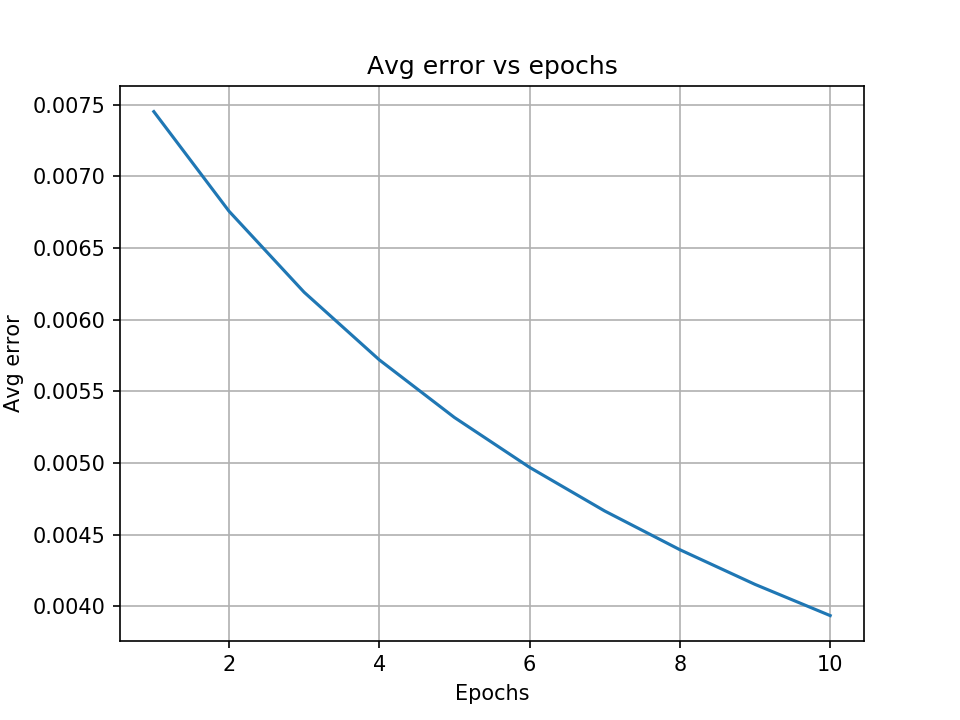

In [51]:
plt.grid(True)
plt.title('Avg error vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Avg error')
plt.plot(range(1, len(model.losses)+1), model.losses)

In [52]:
confusion_matrix(Y_test.argmax(axis=0), predictions.argmax(axis=0))

array([[ 971,    0,    2,    1,    0,    2,    2,    1,    1,    0],
       [   0, 1125,    2,    2,    0,    1,    2,    1,    2,    0],
       [   5,    2, 1000,    6,    5,    0,    2,    6,    5,    1],
       [   0,    0,    6,  991,    1,    1,    0,    5,    5,    1],
       [   1,    0,    2,    0,  955,    0,    5,    1,    2,   16],
       [   4,    1,    0,   11,    1,  860,    8,    1,    3,    3],
       [   9,    3,    0,    2,    2,    6,  933,    0,    3,    0],
       [   1,   12,   11,    4,    1,    1,    0,  989,    0,    9],
       [   4,    0,    1,    3,    4,    4,    3,    5,  948,    2],
       [   6,    6,    1,   11,   12,    2,    1,    6,    2,  962]])